In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import SoapySDR
from SoapySDR import *  # SOAPY_SDR_ constants
import sys
from skimage.exposure import exposure

def plot_spectrogram(im):
    """ Uses rescaling to improve the dynamics. """
    im = np.array(im)
    p2, p98 = np.percentile(im, (1, 99))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))
    
    plt.figure(figsize = (9.75, 10))
    plt.ylabel('Time (sec)')
    yt = np.linspace(0, im.shape[0], 10, endpoint=True)
    plt.yticks(yt, [f'{x * time_per_frame:.2f}' for x in yt])
    
    plt.xlabel('Bandwidth (MHz)')
    xt = np.linspace(0, im.shape[1], 9, endpoint=True)
    plt.xticks(xt, [f'{-40 + i * 10:.2f}' for i in range(len(xt))])
    
    plt.imshow(im, interpolation='nearest', aspect='auto')
    plt.tight_layout()
    plt.grid()
    plt.show()
    
def plot_fft(fft_frame):
    """ Plot single frame from the spectrogram. """
    
    plt.figure(figsize = (9.75, 5))
    
    plt.ylabel('Magnitude (dB)')
    plt.xlabel('Bandwidth (MHz)')
    xt = np.linspace(0, fft_frame.shape, 9, endpoint=True)
    plt.xticks(xt, [f'{-40 + i * 10:.2f}' for i in range(len(xt))])
    
    plt.plot(fft_frame)
    plt.tight_layout()
    plt.grid()
    plt.show()

# Setup the Remote SDR interface

In [2]:
# constants
sample_rate = 80e6 # Known to work in range 40e6 - 80e6
fft_size = 8192
time_axis_averaging = 8
time_per_frame = (1/sample_rate) * (fft_size*time_axis_averaging)

# cacheCalibrations makes Lime interface faster, see https://github.com/myriadrf/LimeSuite/issues/200
sdr_device = SoapySDR.Device({'driver': 'remote', 'cacheCalibrations': '1'}) 
sdr_device.setAntenna(SOAPY_SDR_RX, 0, 'LNAH')
sdr_device.setSampleRate(SOAPY_SDR_RX, 0, sample_rate)
sdr_device.setBandwidth(SOAPY_SDR_RX, 0, sample_rate)
sdr_device.setDCOffsetMode(SOAPY_SDR_RX, 0, True)

gains = {"LNA": 0, "TIA": 0, "PGA": -12}
for gain, value in gains.items():
    sdr_device.setGain(SOAPY_SDR_RX, 0, gain, value)

rx_stream = sdr_device.setupStream(SOAPY_SDR_RX, SOAPY_SDR_CS16, [0],
                    {'remote:mtu': '2120', 'remote:prot': 'tcp'})

def get_batch(center_frequency_mhz, duration_sec):
    sdr_device.setFrequency(SOAPY_SDR_RX, 0, center_frequency_mhz)
    frames = int(duration_sec // time_per_frame)
    rx_buff = np.empty(shape=(frames, 512), dtype=np.int32)
    sdr_device.activateStream(rx_stream)
    for i in range(frames):
        sr = sdr_device.readStream(rx_stream, [rx_buff[i]], 512)
        if sr.ret != 512:
            print('Bad samples from remote!')
    
    sdr_device.deactivateStream(rx_stream)
    ret = np.log10(rx_buff.astype(float) * 2**-43) * 10
    return ret

# Plot 1 second of activity in 2.4G ISM band

<IPython.core.display.Javascript object>


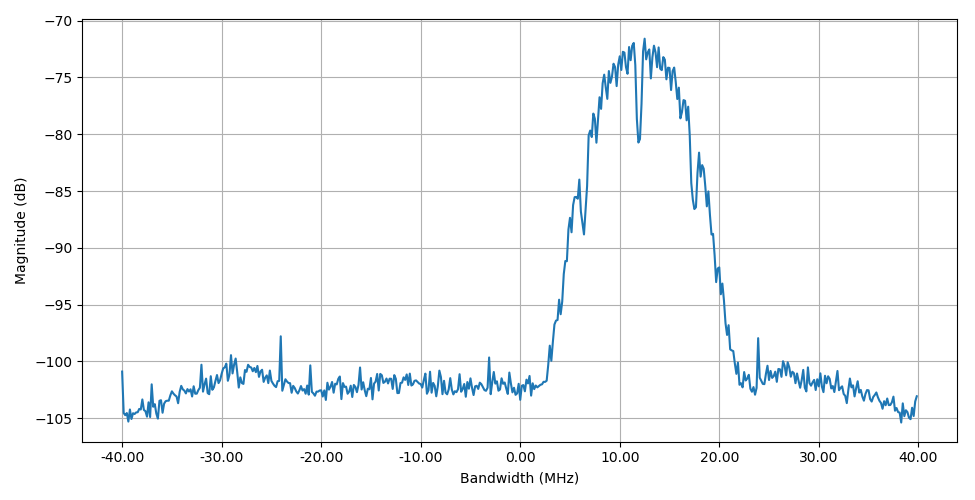

<IPython.core.display.Javascript object>


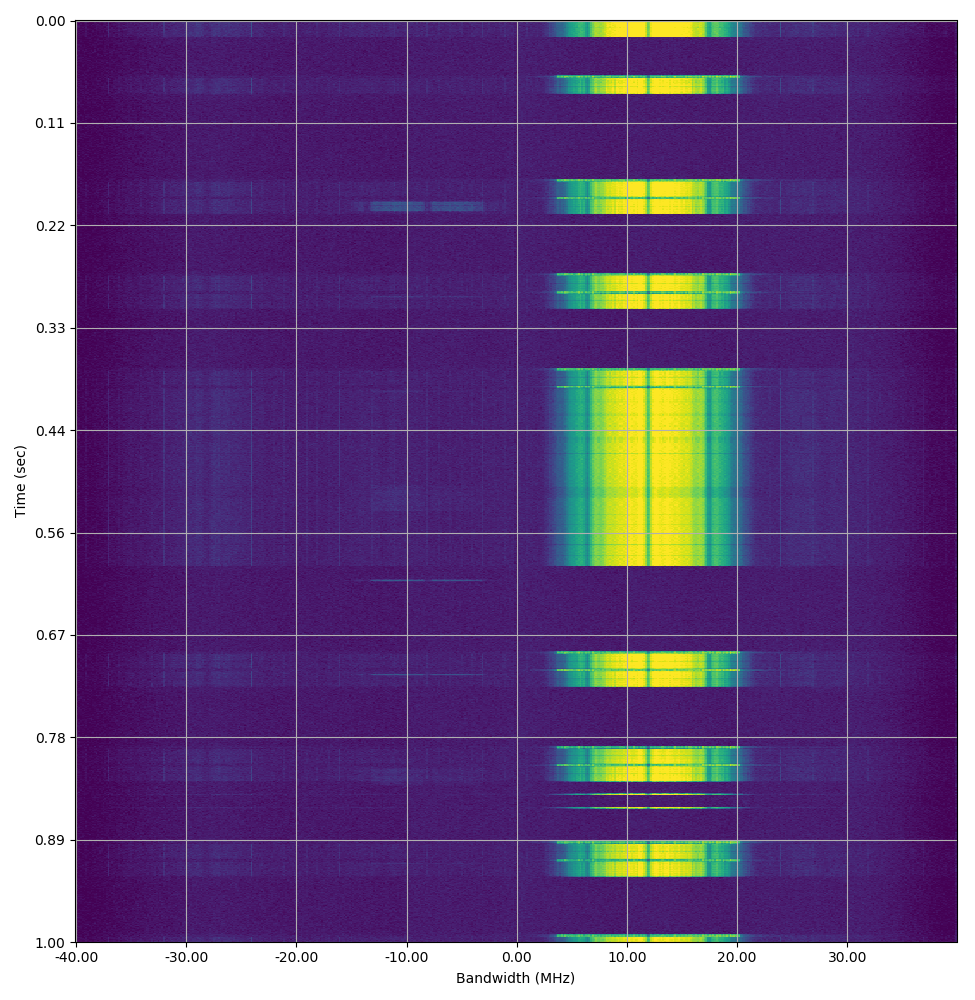

In [9]:
batch = get_batch(center_frequency_mhz=2440e6, duration_sec=1)
plot_fft(batch[10])
plot_spectrogram(batch)